In [125]:
#Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore',message="^internal gelsd")

In [126]:
#loading csv file data
def load_data(path):
    data = pd.read_csv(path)
    df = data.drop(["Survived"],axis=1)
    labels = data['Survived'].values
    return df,labels

df,labels = load_data('./Dataset/train.csv')
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


### Steps
1. remove extra features
2. impute values
3. label/onehot encode categorical features
4. standardize the values
5. choose the best model
6. run grid search 
7. evaluate the model

In [128]:
EXTRA_FEATURES = ['PassengerId','Name','Ticket','Cabin']
INCOMPLETE_FEATURES = ['Age','Embarked']
cat_features = ['Sex','Embarked']

In [129]:
#Removing Extra fetures like name,ticket no.
from sklearn.base import BaseEstimator, TransformerMixin

class RemoveExtraFeatures(BaseEstimator, TransformerMixin):
    def __init__(self,extra_feature_idx=EXTRA_FEATURES):
        self.extra_feature_idx = extra_feature_idx
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X.drop(self.extra_feature_idx,axis=1)

In [130]:
#Filling missing values and onhot encoding categorical features
from sklearn.impute import SimpleImputer

class ImputeAndOneHotEncode(BaseEstimator, TransformerMixin):
    def __init__(self,incomplete_features=INCOMPLETE_FEATURES,cat_features=cat_features):
        self.incomplete_features = incomplete_features
        self.cat_features = cat_features
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        for col in self.incomplete_features:
            if X[col].dtype == "float64":
                imputer = SimpleImputer(strategy='mean')
                X[col] = imputer.fit_transform(X[col].values.reshape(-1,1))
            else:
                imputer = SimpleImputer(strategy="most_frequent")
                X[col] = imputer.fit_transform(X[col].values.reshape(-1,1))

        X = pd.get_dummies(X, columns=self.cat_features)
        return X

In [131]:
#creating a full preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessing_pipeline = Pipeline([
    ('removeExtraFeatures',RemoveExtraFeatures()),
    ('ImputeAndOneHotEncode',ImputeAndOneHotEncode()),
    ('standardScaling',StandardScaler())
])

In [132]:
#preprocessed data
X = preprocessing_pipeline.fit_transform(df)

In [133]:
#Shuffling the data to remove any regularity among the rows
shuffled_idx = np.random.permutation(len(X))

X = X[shuffled_idx]
labels = labels[shuffled_idx]

In [134]:
#creating auxilary df for data viz.
df = df.drop(['PassengerId','Name','Ticket'],axis=1)

In [135]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,NaN,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,NaN,S


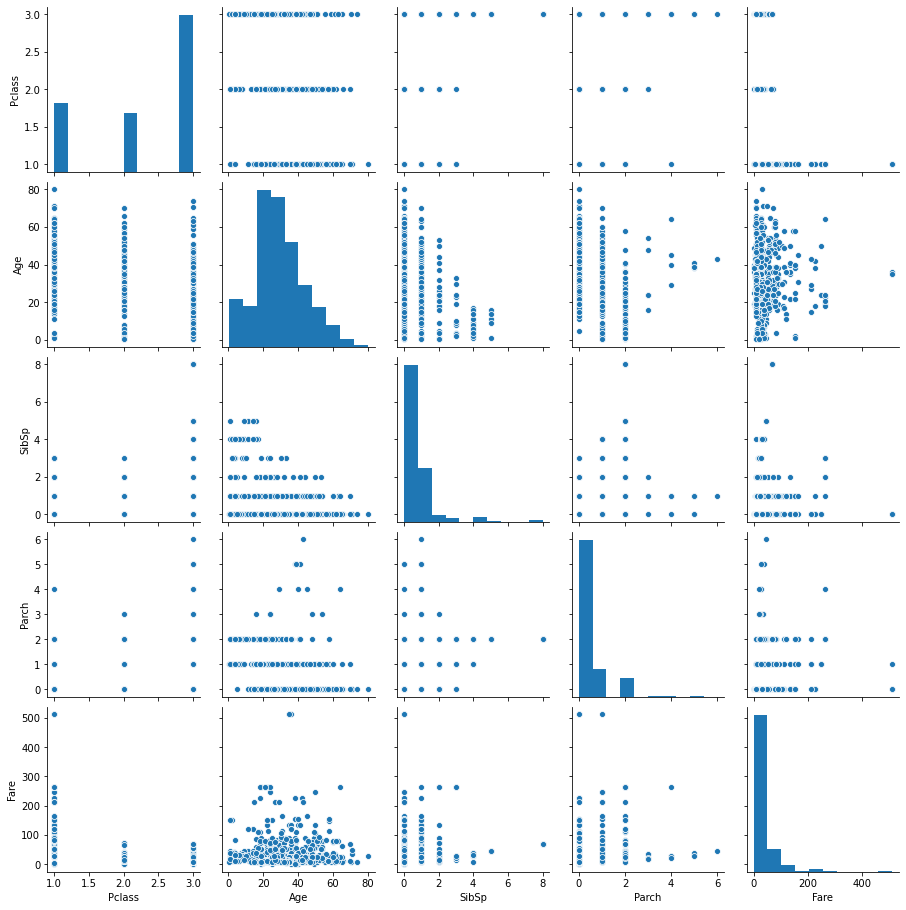

In [136]:
import seaborn as sns
sns.pairplot(df)

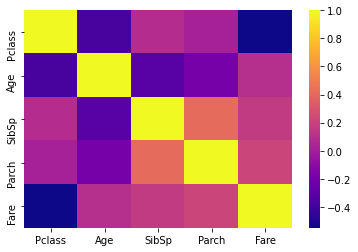

In [137]:
sns.heatmap(df.corr(),cmap='plasma')

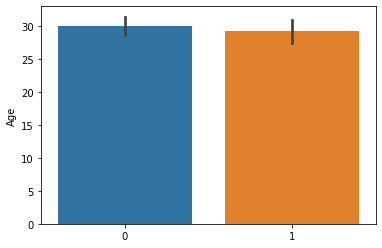

In [138]:
sns.barplot(x=labels,y=df['Age'])

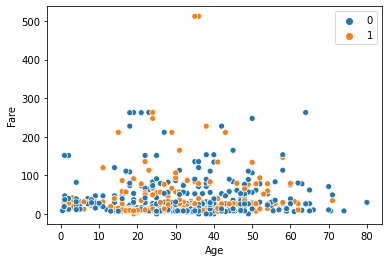

In [139]:
sns.scatterplot(x=df['Age'],y=df['Fare'],hue=labels)

In [140]:
### Models
labels = labels.reshape(-1,1)
X.shape,labels.shape

((891, 10), (891, 1))

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from xgboost import XGBClassifier

In [142]:
lr_clf = LogisticRegression()
svc_clf = SVC()
rf_clf = RandomForestClassifier()
dt_clf = DecisionTreeClassifier()
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier(n_estimators=20)

In [143]:
def fit_and_evaluate_model(model, X=X ,y=labels):
    model.fit(X,y)
    y_pred = model.predict(X)
#     print(confusion_matrix(y,y_pred))
#     print(classification_report(y,y_pred))
    print("training accuracy: ",accuracy_score(y,y_pred))

In [144]:
fit_and_evaluate_model(lr_clf)

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


training accuracy:  0.8002244668911336


In [145]:
fit_and_evaluate_model(svc_clf)

training accuracy:  0.8428731762065096


C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [146]:
fit_and_evaluate_model(rf_clf)

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


training accuracy:  0.9820426487093153


In [147]:
fit_and_evaluate_model(dt_clf)

training accuracy:  0.9820426487093153


In [148]:
fit_and_evaluate_model(knn_clf)

training accuracy:  0.856341189674523


C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [149]:
#Grid Seach for random forest hyperparameters
from sklearn.model_selection import GridSearchCV

n_estimators = [50,100,150,200]
max_depth = [2,3,5]
min_samples_split = [2, 5, 7]
min_samples_leaf = [1, 2, 3] 

rf_clf = RandomForestClassifier()

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid_search = GridSearchCV(rf_clf, param_grid, cv = 2, verbose = 1, n_jobs = -1)
grid_search.fit(X,labels)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   54.9s finished
C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=1)

In [150]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_split=7, n_estimators=50)

In [151]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 50}

In [154]:
#cross validation (may be not effective in small data)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_best,X,labels,cv=10)
scores

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\sklearn\mod

array([0.78888889, 0.86516854, 0.78651685, 0.78651685, 0.80898876,
       0.80898876, 0.85393258, 0.91011236, 0.80898876, 0.82022472])

In [155]:
scores.mean()

0.823832709113608

In [152]:
rf_best = RandomForestClassifier(**grid_search.best_params_)

In [153]:
rf_best.fit(X,labels)

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(max_depth=5, min_samples_split=7, n_estimators=50)

In [156]:
test_df = pd.read_csv('./Dataset/test.csv')
test_labels = pd.read_csv('./Dataset/gender_submission.csv')

In [157]:
fare_mean = test_df['Fare'].mean()
test_df['Fare'].fillna(fare_mean,inplace=True)

In [158]:
X_test = preprocessing_pipeline.transform(test_df)
test_labels = test_labels['Survived'].values

In [159]:
#Testing the model
y_pred = rf_best.predict(X_test)
print(confusion_matrix(test_labels,y_pred))
print(classification_report(test_labels,y_pred))
print("test accuracy: ",accuracy_score(test_labels,y_pred))

[[258   8]
 [ 16 136]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       266
           1       0.94      0.89      0.92       152

    accuracy                           0.94       418
   macro avg       0.94      0.93      0.94       418
weighted avg       0.94      0.94      0.94       418

test accuracy:  0.9425837320574163


In [160]:
print(accuracy_score(test_labels,rf_best.predict(X_test)))

0.9425837320574163


In [120]:
xgb_clf.fit(X,labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [121]:
y_pred = xgb_clf.predict(X)
print(confusion_matrix(labels,y_pred))
print(classification_report(labels,y_pred))

[[524  25]
 [ 57 285]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       549
           1       0.92      0.83      0.87       342

    accuracy                           0.91       891
   macro avg       0.91      0.89      0.90       891
weighted avg       0.91      0.91      0.91       891



In [122]:
y_pred = xgb_clf.predict(X_test)
print(confusion_matrix(test_labels,y_pred))
print(classification_report(test_labels,y_pred))

[[244  22]
 [ 30 122]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       266
           1       0.85      0.80      0.82       152

    accuracy                           0.88       418
   macro avg       0.87      0.86      0.86       418
weighted avg       0.87      0.88      0.87       418



In [ ]:
###